In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import voxelmorph as vxm
#from tensorflow.keras 


2022-02-26 09:55:18.835874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(512, 512, 662) (512, 512, 662)


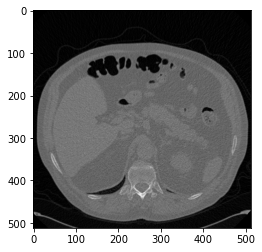

In [2]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata()
mask = nib.load(aw_path).get_fdata()

print(img.shape, mask.shape)

# Visualize CT

plt.imshow(img[:, :, 100], cmap = "gray")
plt.show()

# Model Creation

Turns out we're not going to be using the voxelmorph approach. 

In [5]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

vol_shape = [512, 512, 662]
num_dims = 3

# unet

#unet = vxm.networks.Unet(inshape=vol_shape, 
#    nb_features=[[nb_enc_features], [nb_dec_features]])
#3)

"""
Note: Default Voxelmorph Unet class enc/dec:

        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]

"""

#disp_tensor = layers.Conv3D(num_dims, kernel_size=3, padding='same', name='disp')(unet.output)
#seg_model = Model(unet.inputs)

'\nNote: Default Voxelmorph Unet class enc/dec:\n\n        encoder: [16, 32, 32, 32]\n        decoder: [32, 32, 32, 32, 32, 16, 16]\n\n'

In [7]:
# Model Compilation
#lambda_param = 1e-4

batch_size = 1  # from torch notebook
learning_rate = 1e-2
#loss_weights = [1, lambda_param]

#loss_fn = vxm.losses.Dice().loss
#joptim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#seg_model.compile(optimizer=optim, loss=loss_fn, 
#                    loss_weights=loss_weights
#                    )

In [39]:
#seg_model.summary()
#unet.summary()
#unet.output

<KerasTensor: shape=(None, 512, 512, 16) dtype=float32 (created by layer 'unet_dec_final_conv_2_activation')>

In [8]:
#seg_model.fit(x=img, y=mask, batch_size=1, epochs=100)

In [9]:
#model_hist = seg_model.fit_generator(generator=training_generator,
#                                    #steps_per_epoch = len(train_id) // batch_size,
#                                    steps_per_epoch = 1000,
                                    #validation_data = validation_generator,
                                    #validation_steps = len(valid_id) // batch_size,
#                                    epochs=nb_epochs, 
#                                    callbacks=[#checkpointer, 
                                                #checkpointer2, 
#                                                earlystopper, 
#                                                reduce_lr, 
#                                                terminate_nan])

  #"""
#weights_path = os.path.join(dir_global, 'models/weights_' + model_string + '_iter' + format(i,"03") +'.h5')
#vxm_model.save_weights(weights_path)

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    #model = Model(input = inputs, output = conv10)
    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [15]:
model = unet(input_size=(512,512,662,1))

In [16]:
model.summary()
model.output

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 66 0                                            
__________________________________________________________________________________________________
conv3d_24 (Conv3D)              (None, 512, 512, 662 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_25 (Conv3D)              (None, 512, 512, 662 110656      conv3d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_4 (MaxPooling3D)  (None, 256, 256, 331 0           conv3d_25[0][0]                  
____________________________________________________________________________________________

<KerasTensor: shape=(None, 512, 512, 3296, 1) dtype=float32 (created by layer 'conv3d_47')>

In [17]:
model.fit(x=img, y=mask)
# TODO troubleshoot incorrect dimensions

2022-02-26 10:02:17.572943: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 694157312 exceeds 10% of free system memory.
2022-02-26 10:02:40.032567: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 694157312 exceeds 10% of free system memory.


ValueError: in user code:

    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jtabalon/anaconda3/envs/tf_airway/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 512, 512, 662, 1), found shape=(32, 512, 662)
